In [2]:
#! pip install psycopg2-binary
# Import dependencies
import pandas as pd # Data manipulation
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb
import psycopg2
import json
from sqlalchemy import create_engine


In [3]:
# Load credentials
with open("../../db_config.json") as f:
    config = json.load(f)

In [4]:
# Connect to PostgreSQL
conn = psycopg2.connect(
    host=config["host"],
    port=config["port"],
    database=config["database"],
    user=config["user"],
    password=config["password"]
)

# Create SQLAlchemy engine
engine = create_engine(f"postgresql+psycopg2://{config['user']}:{config['password']}@{config['host']}:{config['port']}/{config['database']}")


In [45]:
df_borrower = pd.read_sql("SELECT * FROM borrower_info;", engine)
df_borrower.head()

,member_id,home_ownership,merged_annual_inc,merged_dti,emp_length_grouped,clean_verification_status,merged_purpose
0,1,RENT,55000.0,18.24,10+ years,Not Verified,Debt-related
1,3,MORTGAGE,59280.0,10.51,4-6 years,Verified,Debt-related
2,5,MORTGAGE,57250.0,26.35,10+ years,Not Verified,Debt-related
3,6,MORTGAGE,152500.0,37.94,10+ years,Not Verified,Debt-related
4,9,MORTGAGE,53580.0,21.16,10+ years,Verified,Debt-related


In [46]:
df_loan = pd.read_sql("SELECT * FROM loan_info;", engine)
df_loan.head()

,loan_id,member_id,funded_amnt,term,int_rate,grade,loan_status
0,loan1,1,2500,36 months,13.56,C,Current
1,loan2,2,30000,60 months,18.94,D,Current
2,loan3,3,5000,36 months,17.97,D,Current
3,loan4,4,4000,36 months,18.94,D,Current
4,loan5,5,30000,60 months,16.14,C,Current


In [47]:
df_credit_history = pd.read_sql("SELECT * FROM credit_history;", engine)
df_credit_history.head()

,loan_id,all_util,avg_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bc_limit
0,loan1,28.0,1878.0,60124.0,34.0,16901.0,36500.0
1,loan2,57.0,24763.0,372872.0,44.0,99468.0,15000.0
2,loan3,35.0,18383.0,136927.0,13.0,11749.0,13800.0
3,loan4,70.0,30505.0,385183.0,13.0,36151.0,5000.0
4,loan5,54.0,9667.0,157548.0,26.0,29674.0,9300.0


In [48]:
df_delinquency = pd.read_sql("SELECT * FROM delinquency_info;", engine)
df_delinquency.head()

,loan_id,delinq_amnt,delinq_bucket,acc_now_delinq_bucketed,delinq_2yrs_bucketed,accounts_90d_past_due_24m,total_chargeoffs_within_12_mths,pub_rec_bankruptcies_bucketed,percent_bc_gt_75_bucketed,pct_tl_nvr_dlq_bucketed,open_acc_bucketed
0,loan1,0.0,Unknown,No Delinquencies,0,0,0,1,0,100.0,6-10
1,loan2,0.0,Unknown,No Delinquencies,0,0,0,0,50.1-75%,100.0,6-10
2,loan3,0.0,61+ months,No Delinquencies,0,0,0,1,0,90-99.9,11-15
3,loan4,0.0,Unknown,No Delinquencies,0,0,0,0,0,100.0,11-15
4,loan5,0.0,Unknown,No Delinquencies,0,0,0,0,0,100.0,6-10


In [49]:
# Merge borrower_info on member_id
df_merged = df_loan.merge(df_borrower, on="member_id", how="left")

# Merge credit_history on loan_id
df_merged = df_merged.merge(df_credit_history, on="loan_id", how="left")

# Merge delinquency_info on loan_id
df_loans_post= df_merged.merge(df_delinquency, on="loan_id", how="left")

# Show final dataset
df_loans_post.head()

,loan_id,member_id,funded_amnt,term,int_rate,grade,loan_status,home_ownership,merged_annual_inc,merged_dti,...,delinq_amnt,delinq_bucket,acc_now_delinq_bucketed,delinq_2yrs_bucketed,accounts_90d_past_due_24m,total_chargeoffs_within_12_mths,pub_rec_bankruptcies_bucketed,percent_bc_gt_75_bucketed,pct_tl_nvr_dlq_bucketed,open_acc_bucketed
0,loan1,1,2500,36 months,13.56,C,Current,RENT,55000.0,18.24,...,0.0,Unknown,No Delinquencies,0,0,0,1,0,100.0,6-10
1,loan2,2,30000,60 months,18.94,D,Current,MORTGAGE,90000.0,26.52,...,0.0,Unknown,No Delinquencies,0,0,0,0,50.1-75%,100.0,6-10
2,loan3,3,5000,36 months,17.97,D,Current,MORTGAGE,59280.0,10.51,...,0.0,61+ months,No Delinquencies,0,0,0,1,0,90-99.9,11-15
3,loan4,4,4000,36 months,18.94,D,Current,MORTGAGE,92000.0,16.74,...,0.0,Unknown,No Delinquencies,0,0,0,0,0,100.0,11-15
4,loan5,5,30000,60 months,16.14,C,Current,MORTGAGE,57250.0,26.35,...,0.0,Unknown,No Delinquencies,0,0,0,0,0,100.0,6-10


In [52]:
df_loans= df_loans_post.copy()

In [73]:
df_loans = df_loans[['member_id', 'funded_amnt', 'term', 'int_rate', 'grade',
       'loan_status', 'home_ownership', 'merged_annual_inc', 'merged_dti',
       'emp_length_grouped', 'clean_verification_status', 'merged_purpose',
       'all_util', 'avg_cur_bal', 'tot_hi_cred_lim', 'total_acc',
       'total_bal_ex_mort', 'total_bc_limit', 'delinq_amnt', 'delinq_bucket',
       'acc_now_delinq_bucketed', 'delinq_2yrs_bucketed',
       'accounts_90d_past_due_24m', 'total_chargeoffs_within_12_mths',
       'pub_rec_bankruptcies_bucketed', 'percent_bc_gt_75_bucketed',
       'pct_tl_nvr_dlq_bucketed', 'open_acc_bucketed']]

In [40]:
# # Getting the data into a pandas dataframe
# df_loans = pd.read_csv("Resources/df_subset.csv")
# # show the dataframe
# df_loans.head()

,member_id,all_util,avg_cur_bal,delinq_amnt,funded_amnt,home_ownership,int_rate,term,tot_hi_cred_lim,total_acc,...,clean_verification_status,delinq_bucket,acc_now_delinq_bucketed,delinq_2yrs_bucketed,accounts_90d_past_due_24m,total_chargeoffs_within_12_mths,open_acc_bucketed,pct_tl_nvr_dlq_bucketed,percent_bc_gt_75_bucketed,pub_rec_bankruptcies_bucketed
0,1,28.0,1878.0,0.0,2500,RENT,13.56,36 months,60124.0,34.0,...,Not Verified,Unknown,No Delinquencies,0,0,0,6-10,100.0,0,1
1,2,57.0,24763.0,0.0,30000,MORTGAGE,18.94,60 months,372872.0,44.0,...,Verified,61+ months,No Delinquencies,0,0,0,11-15,90-99.9,0,1
2,3,35.0,18383.0,0.0,5000,MORTGAGE,17.97,36 months,136927.0,13.0,...,Verified,Unknown,No Delinquencies,0,0,0,6-10,100.0,0,0
3,4,70.0,30505.0,0.0,4000,MORTGAGE,18.94,36 months,385183.0,13.0,...,Verified,Unknown,No Delinquencies,0,0,0,6-10,100.0,75.1-100%,0
4,5,54.0,9667.0,0.0,30000,MORTGAGE,16.14,60 months,157548.0,26.0,...,Not Verified,Unknown,No Delinquencies,0,0,0,11-15,90-99.9,0,0


In [74]:
# Dividing dataframe into two dataframes one for Good loans where Grade is A ,B and C
# and one for Bad loans where Grade is D, E, F and G
df_good_loans = df_loans[df_loans['grade'].isin(['A', 'B', 'C'])].copy()
df_bad_loans = df_loans[df_loans['grade'].isin(['D', 'E', 'F', 'G'])].copy()

Working on Good_loans

In [70]:
print(df_good_loans.shape)

(1746637, 29)


In [85]:
df_good_loans.columns

Index(['member_id', 'funded_amnt', 'term', 'int_rate', 'grade', 'loan_status',
       'home_ownership', 'merged_annual_inc', 'merged_dti',
       'emp_length_grouped', 'clean_verification_status', 'merged_purpose',
       'all_util', 'avg_cur_bal', 'tot_hi_cred_lim', 'total_acc',
       'total_bal_ex_mort', 'total_bc_limit', 'delinq_amnt', 'delinq_bucket',
       'acc_now_delinq_bucketed', 'delinq_2yrs_bucketed',
       'accounts_90d_past_due_24m', 'total_chargeoffs_within_12_mths',
       'pub_rec_bankruptcies_bucketed', 'percent_bc_gt_75_bucketed',
       'pct_tl_nvr_dlq_bucketed', 'open_acc_bucketed', 'target'],
      dtype='object')

In [77]:
# Assign target for Good Loans: 1 = 'C', 0 = 'A'/'B'
df_good_loans['target'] = df_good_loans['grade'].apply(lambda x: 1 if x == 'C' else 0)

In [78]:
for col in df_good_loans.select_dtypes(include='object').columns:
    print(col, df_good_loans[col].nunique())


term 2
grade 3
loan_status 9
home_ownership 6
emp_length_grouped 5
clean_verification_status 2
merged_purpose 6
delinq_bucket 6
acc_now_delinq_bucketed 2
percent_bc_gt_75_bucketed 6
pct_tl_nvr_dlq_bucketed 5
open_acc_bucketed 7


In [79]:
df_good_loans.columns

Index(['member_id', 'funded_amnt', 'term', 'int_rate', 'grade', 'loan_status',
       'home_ownership', 'merged_annual_inc', 'merged_dti',
       'emp_length_grouped', 'clean_verification_status', 'merged_purpose',
       'all_util', 'avg_cur_bal', 'tot_hi_cred_lim', 'total_acc',
       'total_bal_ex_mort', 'total_bc_limit', 'delinq_amnt', 'delinq_bucket',
       'acc_now_delinq_bucketed', 'delinq_2yrs_bucketed',
       'accounts_90d_past_due_24m', 'total_chargeoffs_within_12_mths',
       'pub_rec_bankruptcies_bucketed', 'percent_bc_gt_75_bucketed',
       'pct_tl_nvr_dlq_bucketed', 'open_acc_bucketed', 'target'],
      dtype='object')

**Loading and Preprocessing Loans Encoded Data**

In [80]:
# Define the feature set
X= df_good_loans.drop(columns=['grade', 'target','int_rate'], axis=1)
# Define the target variable
y= df_good_loans['target']
# Encode the categorical variables using get_dummies
X = pd.get_dummies(X)
# Cleaning special characters from column names
X.columns = X.columns.astype(str).map(lambda x: x.replace('[', '_').replace(']', '_').replace('<', '_'))
#impute missing in X with median
imp = SimpleImputer(strategy='median')
X = pd.DataFrame(imp.fit_transform(X), columns=X.columns)
# scale the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)
# use SMOTE to generate samples for the minority class
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_res), y=y_res)
class_weights = dict(enumerate(class_weights))

c:\Users\seyhr\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [81]:
# Define the model architecture
nn = Sequential()

# First hidden layer
nn.add(Dense(units=80, activation='relu', input_dim=X_res.shape[1]))
nn.add(BatchNormalization())
nn.add(Dropout(0.4))

# Second hidden layer
nn.add(Dense(units=30, activation='relu'))
nn.add(BatchNormalization())
nn.add(Dropout(0.3))

# Output layer
nn.add(Dense(units=1, activation='sigmoid'))  # For binary classification

# Compile the model
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [82]:
## Fit the model with class weights
history = nn.fit(
    X_res, y_res,
    validation_split=0.2,
    epochs=30,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1,
    class_weight=class_weights
)

Epoch 1/30
5141/5141 [==============================] - 21s 4ms/step - loss: 0.5783 - accuracy: 0.6962 - val_loss: 0.8113 - val_accuracy: 0.4516
Epoch 2/30
5141/5141 [==============================] - 23s 4ms/step - loss: 0.5659 - accuracy: 0.7043 - val_loss: 0.8034 - val_accuracy: 0.4560
Epoch 3/30
5141/5141 [==============================] - 23s 4ms/step - loss: 0.5636 - accuracy: 0.7063 - val_loss: 0.8081 - val_accuracy: 0.4535
Epoch 4/30
5141/5141 [==============================] - 23s 4ms/step - loss: 0.5619 - accuracy: 0.7077 - val_loss: 0.8051 - val_accuracy: 0.4606
Epoch 5/30
5141/5141 [==============================] - 23s 4ms/step - loss: 0.5609 - accuracy: 0.7081 - val_loss: 0.8116 - val_accuracy: 0.4565
Epoch 6/30
5141/5141 [==============================] - 22s 4ms/step - loss: 0.5601 - accuracy: 0.7085 - val_loss: 0.7978 - val_accuracy: 0.4626
Epoch 7/30
5141/5141 [==============================] - 21s 4ms/step - loss: 0.5595 - accuracy: 0.7089 - val_loss: 0.8117 - val_ac

In [83]:
# Evaluate the model on the test set
y_pred_probs = nn.predict(X_test).flatten()
# Convert probabilities to binary predictions using a threshold
threshold = 0.45
y_pred = (y_pred_probs >= threshold).astype(int)

13646/13646 [==============================] - 18s 1ms/step


Classification Report for Good Loan Model:
              precision    recall  f1-score   support

           0     0.7577    0.7952    0.7760    274146
           1     0.6231    0.5711    0.5960    162514

    accuracy                         0.7118    436660
   macro avg     0.6904    0.6832    0.6860    436660
weighted avg     0.7076    0.7118    0.7090    436660

Confusion Matrix:
[[218006  56140]
 [ 69705  92809]]


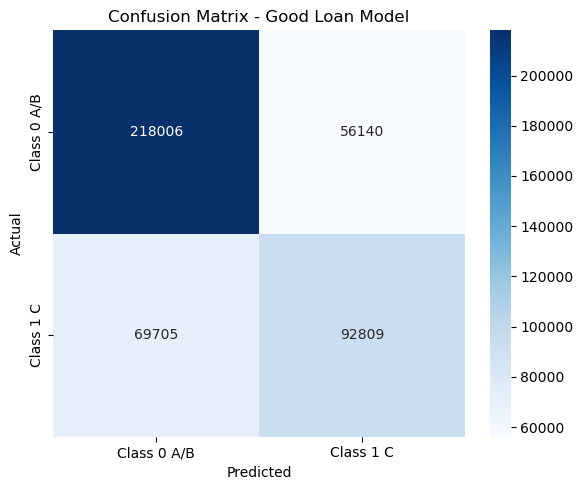

In [84]:
print("Classification Report for Good Loan Model:")
print(classification_report(y_test, y_pred, digits=4))


cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

labels = ["Class 0 A/B", "Class 1 C"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Good Loan Model')
plt.tight_layout()
plt.show()



In [ ]:
# Save the model
#nn.save("models/Gloan_model.h5")  # Save Keras model in .h5 format
# Save scaler
#joblib.dump(scaler, "models/Gloan_scaler.pkl")

['models/Gloan_scaler.pkl']

Bad Loan Model

In [87]:
# Assign target for Bad Loan: 0 = 'D', 1 = 'E'/'F'/'G'
df_bad_loans['target'] = df_bad_loans['grade'].apply(lambda x: 1 if x in ['E','F','G'] else 0)


In [88]:
# Define the feature set
X= df_bad_loans.drop(columns=['grade', 'target','int_rate'], axis=1)
# Define the target variable
y= df_bad_loans['target']
# Encode the categorical variables using get_dummies
X = pd.get_dummies(X)
# Cleaning special characters from column names
X.columns = X.columns.astype(str).map(lambda x: x.replace('[', '_').replace(']', '_').replace('<', '_'))
#impute missing in X with median
imp = SimpleImputer(strategy='median')
X = pd.DataFrame(imp.fit_transform(X), columns=X.columns)
# scale the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)
# use SMOTE to generate samples for the minority class
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
# Compute class weights to handle class imbalance
#class_weights = compute_class_weight('balanced', classes=np.unique(y_res), y=y_res)
#class_weights = dict(enumerate(class_weights))

c:\Users\seyhr\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [ ]:
# # Define the model architecture
# B_nn = Sequential()

# # First hidden layer
# B_nn.add(Dense(units=80, activation='relu', input_dim=X_res.shape[1]))
# B_nn.add(BatchNormalization())
# B_nn.add(Dropout(0.4))

# # Second hidden layer
# B_nn.add(Dense(units=30, activation='relu'))
# B_nn.add(BatchNormalization())
# B_nn.add(Dropout(0.3))

# # Output layer
# B_nn.add(Dense(units=1, activation='sigmoid'))  # For binary classification

# # Compile the model
# B_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Define early stopping callback
# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [ ]:
# ## Fit the model with class weights
# history = B_nn.fit(
#     X_res, y_res,
#     validation_split=0.2,
#     epochs=30,
#     batch_size=256,
#     callbacks=[early_stop],
#     verbose=1
#     #class_weight=class_weights
# )

In [ ]:
# # Evaluate the model on the test set
# y_pred_probs = nn.predict(X_test).flatten()
# # Convert probabilities to binary predictions using a threshold
# threshold = 0.35
# y_pred = (y_pred_probs >= threshold).astype(int)

In [ ]:
# print("Classification Report for Bad Loan Model:")
# print(classification_report(y_test, y_pred, digits=4))


# cm = confusion_matrix(y_test, y_pred)
# print("Confusion Matrix:")
# print(cm)

# plt.figure(figsize=(6, 5))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix - Good Loan Model')
# plt.tight_layout()
# plt.show()



In [89]:
# Instantiate the model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=1,  # tune this if data is imbalanced
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# Fit the model
xgb_model.fit(X_train, y_train)


c:\Users\seyhr\anaconda3\envs\dev\lib\site-packages\xgboost\training.py:183: UserWarning: [13:54:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

Classification Report - XGBoost: Bad Loans Model
              precision    recall  f1-score   support

           0     0.7399    0.7926    0.7654     81106
           1     0.5960    0.5234    0.5573     47402

    accuracy                         0.6933    128508
   macro avg     0.6680    0.6580    0.6613    128508
weighted avg     0.6868    0.6933    0.6886    128508

Confusion Matrix:
 [[64287 16819]
 [22594 24808]]


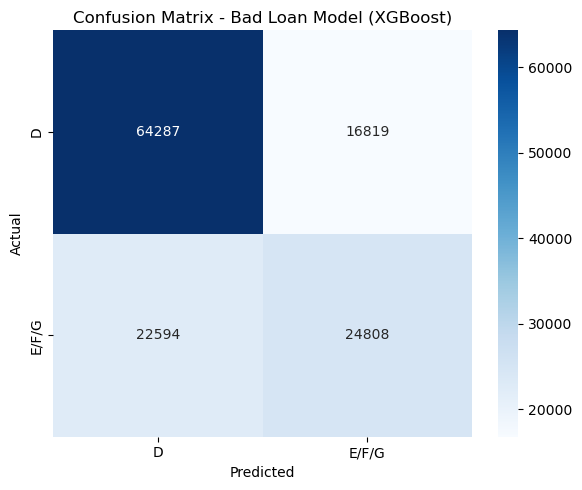

In [90]:

# # Neural network prediction
# nn_probs = nn.predict(X_test).flatten()
# nn_pred = (nn_probs >= 0.45).astype(int)

# XGBoost prediction
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
xgb_pred = (xgb_probs >= 0.45).astype(int)

# # NN Evaluation
# print("Classification Report - Neural Network:")
# print(classification_report(y_test, nn_pred, digits=4))
# print("Confusion Matrix:\n", confusion_matrix(y_test, nn_pred))

# XGBoost Evaluation
print("Classification Report - XGBoost: Bad Loans Model")
print(classification_report(y_test, xgb_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))

# plot confusion matrix for xgboost
# Bad Loan: 1 = 'D', 0 = 'E'/'F'/'G'
labels = ["D", "E/F/G"]
cm = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Bad Loan Model (XGBoost)')
plt.tight_layout()
plt.show()

In [ ]:
# save the model
#xgb_model.save_model("models/Bad_Loan_Model.json")

In [ ]:
# Close database connection
engine.dispose()